In [2]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
np.random.seed(42)

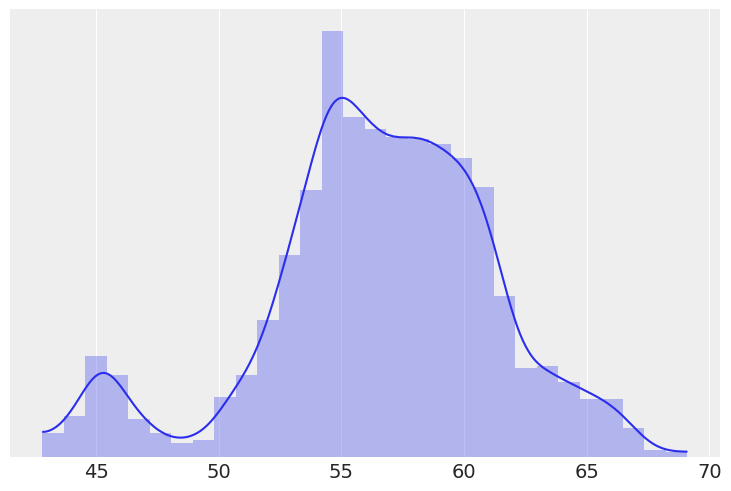

In [4]:
cs = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
az.plot_kde(cs_exp)
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])
plt.savefig('B11197_06_02.png')

In [5]:
#with pm.Model() as model_kg:
#    p = pm.Dirichlet('p', a=np.ones(clusters))
#    z = pm.Categorical('z', p=p, shape=len(cs_exp))
#    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
#    sd = pm.HalfNormal('sd', sd=10)
#
#    y = pm.Normal('y', mu=means[z], sd=sd, observed=cs_exp)
#    trace_kg = pm.sample()

In [6]:
clusters = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mg = pm.sample(random_seed=123)

/Users/gdupret/Projects/pymc3/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/gdupret/Projects/pymc3/venv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


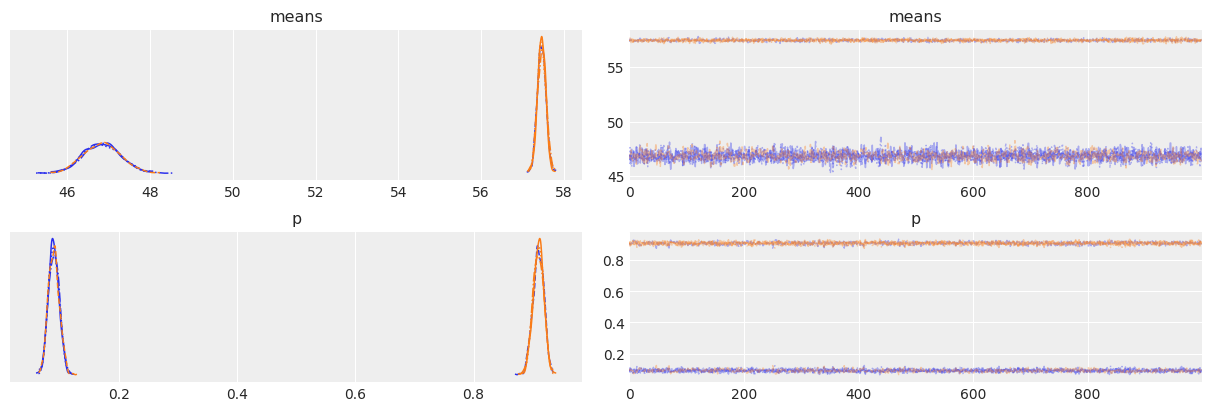

In [7]:
varnames = ['means', 'p']
az.plot_trace(trace_mg, varnames)
plt.savefig('B11197_06_06.png')

In [8]:
az.summary(trace_mg, varnames)

/Users/gdupret/Projects/pymc3/venv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],49.494,4.619,46.172,57.629,2.293,1.756,4.0,4.0,7.0,30.0,1.53
means[1],54.808,4.607,46.494,57.721,2.292,1.755,4.0,4.0,7.0,31.0,1.53
p[0],0.295,0.355,0.075,0.920,0.177,0.135,4.0,4.0,7.0,30.0,1.53
p[1],0.705,0.355,0.080,0.925,0.177,0.135,4.0,4.0,7.0,30.0,1.53


## Non-identifiability of mixture models

In [9]:
clusters = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=np.array([.9, 1]) * cs_exp.mean(),
                      sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    order_means = pm.Potential('order_means',
                               tt.switch(means[1]-means[0] < 0,
                                         -np.inf, 0))
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mgp = pm.sample(1000, random_seed=123)

/Users/gdupret/Projects/pymc3/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.


In [10]:
# instead of a potential we can use an ordered transformation
# transform=pm.distributions.transforms.ordered

/Users/gdupret/Projects/pymc3/venv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


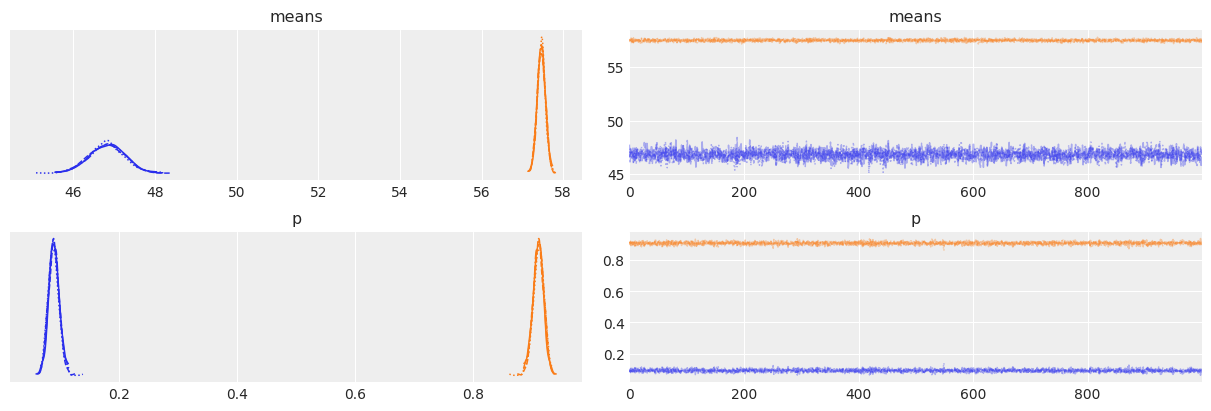

In [11]:
varnames = ['means', 'p']
az.plot_trace(trace_mgp, varnames)
plt.savefig('B11197_06_07.png')

In [12]:
az.summary(trace_mgp)

/Users/gdupret/Projects/pymc3/venv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],46.820,0.435,45.970,47.609,0.007,0.005,3740.0,3740.0,3743.0,3228.0,1.0
means[1],57.465,0.100,57.283,57.658,0.001,0.001,4524.0,4524.0,4525.0,2968.0,1.0
p[0],0.090,0.009,0.074,0.107,0.000,0.000,3682.0,3680.0,3692.0,3106.0,1.0
p[1],0.910,0.009,0.893,0.926,0.000,0.000,3682.0,3681.0,3692.0,3106.0,1.0
sd,3.652,0.074,3.521,3.799,0.001,0.001,4736.0,4726.0,4741.0,2837.0,1.0


## How to choose K

In [13]:
clusters = [3, 4, 5, 6]

models = []
traces = []
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means',
                          mu=np.linspace(cs_exp.min(), cs_exp.max(), cluster),
                          sd=10, shape=cluster,
                          transform=pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
        trace = pm.sample(1000, tune=2000, random_seed=123)
        traces.append(trace)
        models.append(model)

/Users/gdupret/Projects/pymc3/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 55 seconds.
/Users/gdupret/Projects/pymc3/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sa

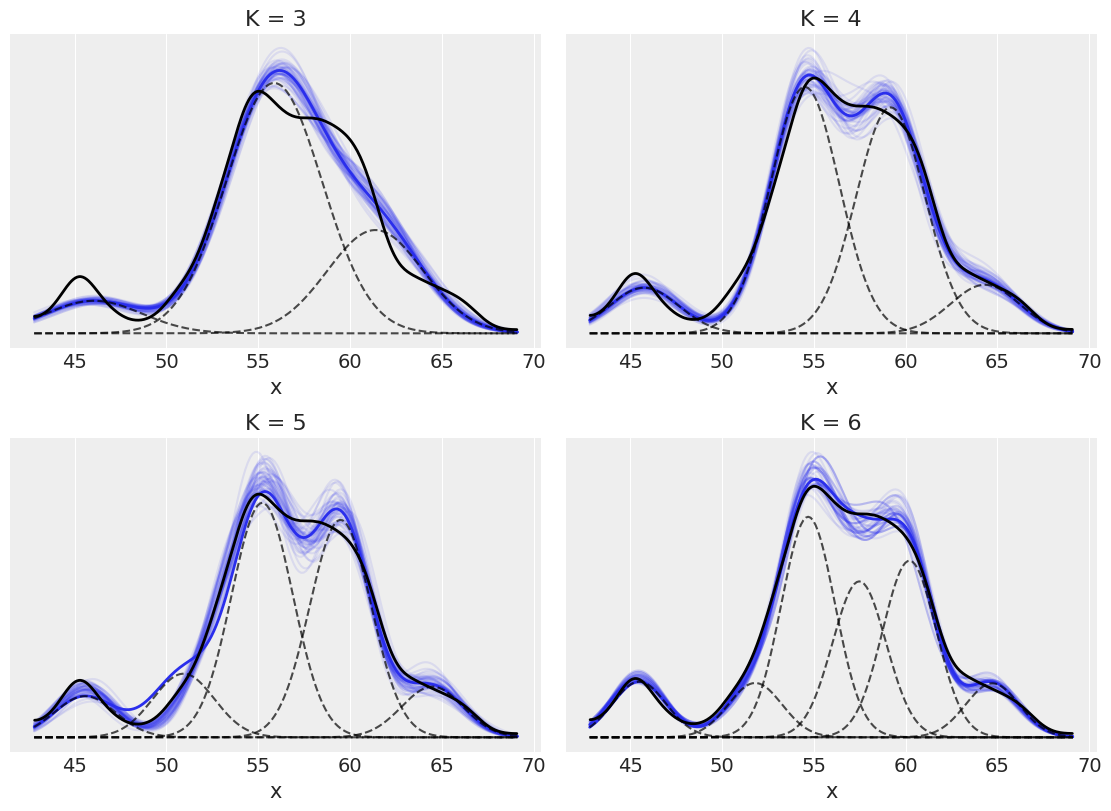

In [14]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
 
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, trace_x in enumerate(traces):
    x_ = np.array([x] * clusters[idx]).T
 
    for i in range(50):
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x['means'][i_]
        p_y = trace_x['p'][i_]
        sd = trace_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', alpha=0.1)
 
    means_y = trace_x['means'].mean(0)
    p_y = trace_x['p'].mean(0)
    sd = trace_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, 'k--', alpha=0.7)
         
    az.plot_kde(cs_exp, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')
plt.savefig('B11197_06_08.png')

In [15]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], 1000, models[i])
          for i in range(4)]

/Users/gdupret/Projects/pymc3/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
/Users/gdupret/Projects/pymc3/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


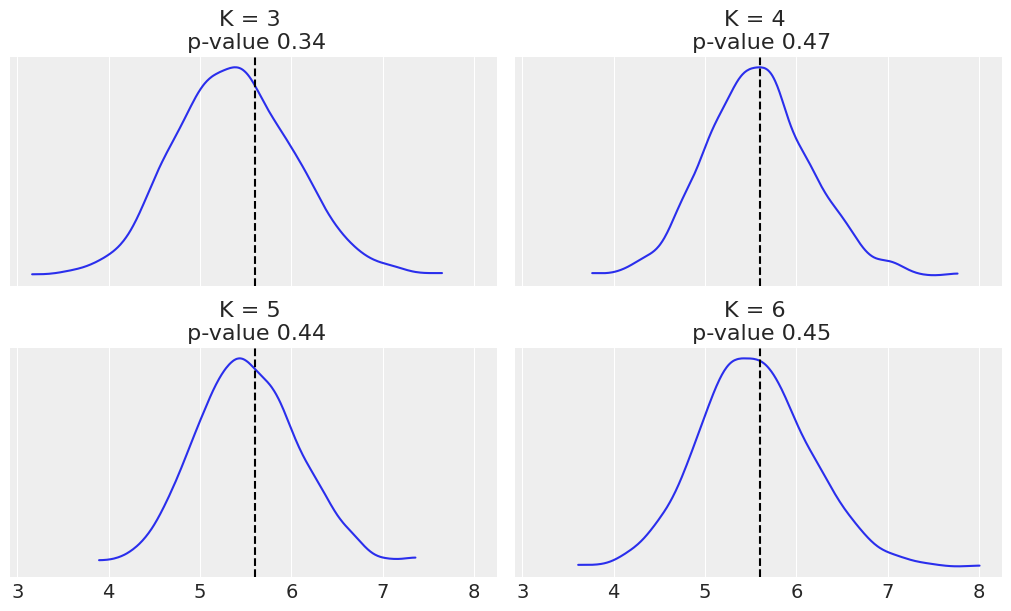

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])
plt.savefig('B11197_06_09.png')

In [17]:
comp = az.compare(dict(zip(clusters, traces)), method='BB-pseudo-BMA')
comp

/Users/gdupret/Projects/pymc3/venv/lib/python3.9/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/gdupret/Projects/pymc3/venv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/gdupret/Projects/pymc3/venv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/gdupret/Projects/pymc3/venv/lib/python3.9/site-packages/arviz/data/i

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
6,0,-5124.565706,10.881770,0.000000,9.977229e-01,30.841953,0.000000,False,log
5,1,-5133.369374,12.185773,8.803668,1.580771e-03,30.195315,2.326718,False,log
4,2,-5139.632828,7.657737,15.067123,6.963325e-04,29.836427,4.633142,False,log
3,3,-5178.580198,6.049873,54.014492,1.297619e-14,29.631092,9.154720,False,log


KeyError: 0

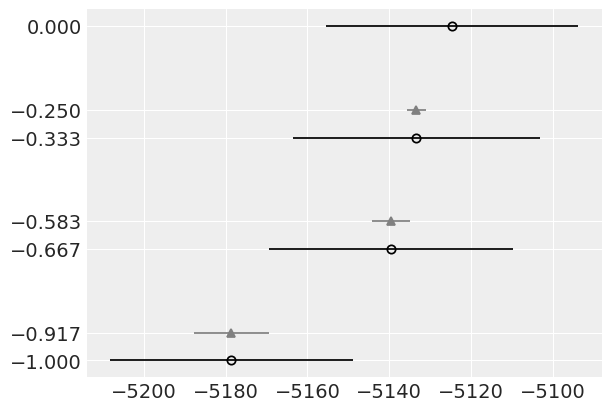

In [18]:
az.plot_compare(comp)
plt.savefig('B11197_06_10.png')

## Non-finite mixture model

In [1]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    
    Parameters
    ----------
    α : float
        concentration parameter
    H : scipy distribution
        Base distribution
    K : int
        number of components
    
    Returns
    -------
    locs : array
        locations
    w : array
        probabilities
    """
    βs = stats.beta.rvs(1, α, size=K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    locs = H.rvs(size=K)
    return locs, w

# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]

# plot
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0')
    ax[idx].set_title('α = {}'.format(α))

plt.tight_layout()
plt.savefig('B11197_06_11.png')

NameError: name 'stats' is not defined

In [ ]:
α = 10
H = stats.norm
K = 5

x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)

dist = stats.laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])
plt.savefig('B11197_06_12.png')

In [ ]:
K = 20

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [ ]:
with pm.Model() as model:
    α = pm.Gamma('α', 1, 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means',
                      mu=np.linspace(cs_exp.min(), cs_exp.max(), K),
                      sd=10, shape=K)
    
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp.values)
    trace = pm.sample(1000, tune=2000, nuts_kwargs={'target_accept':0.85})

In [ ]:
az.plot_trace(trace, var_names=['α'], divergences=False);
plt.savefig('B11197_06_13.png')

In [ ]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, trace['w'].mean(0), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')
plt.savefig('B11197_06_14.png')

In [ ]:
x_plot = np.linspace(cs.exp.min()-1, cs.exp.max()+1, 200)

post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   trace['means'][:, np.newaxis, :],
                                   trace['sd'][:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(cs_exp.values, bins=25, density=True, alpha=0.5)
plt.plot(x_plot, post_pdfs[::100].T, c='0.5')
plt.plot(x_plot, post_pdfs.mean(axis=0), c='k')

plt.xlabel('x')
plt.yticks([])
plt.savefig('B11197_06_15.png')

In [ ]:
## Exercises
#clusters = 3
#n_cluster = [200, 150, 170]
#n_total = sum(n_cluster)
#means = [5, 0, -3]
#std_devs = [2, 2, 2]
#mix = np.random.normal(np.repeat(means, n_cluster),
#np.repeat(std_devs, n_cluster))
#az.plot_kde(np.array(mix));